<a href="https://colab.research.google.com/github/UERJ-FISICA/ML4PPGF_UERJ/blob/PPGF-2023-2/VAE_D%C3%ADgitos_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from joblib import dump, load

import sklearn
import tensorflow as tf
from tensorflow import keras

print ( "sklearn: {}".format(sklearn.__version__) )
print ( "tensorflow: {}".format(tf.__version__) )

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
print ( gpus )

sklearn: 1.2.2
tensorflow: 2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:50000])]))[:, 1]
    reorder_valid = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[50000:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:50000] = mnist.data[reorder_train]
    mnist.target[:50000] = mnist.target[reorder_train]
    mnist.data[50000:60000] = mnist.data[reorder_valid + 50000]
    mnist.target[50000:60000] = mnist.target[reorder_valid + 50000]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)
data = mnist.data.reshape( -1, 28, 28, 1 ).astype( np.float32 )
target = mnist.target
X_train_raw = data[:50000]
y_train = target[:50000]
X_valid_raw = data[50000:60000]
y_valid = target[50000:60000]
X_test_raw = data[60000:]
y_test = target[60000:]

print ( X_train_raw.shape, X_train_raw.dtype )
print ( X_valid_raw.shape, X_valid_raw.dtype )
print ( X_test_raw.shape, X_test_raw.dtype )

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(50000, 28, 28, 1) float32
(10000, 28, 28, 1) float32
(10000, 28, 28, 1) float32


In [3]:
# X_train = X_train_raw / 255.
# X_valid = X_valid_raw / 255.
# X_test  = X_test_raw / 255.
def process( imgs ):
    imgs__ = imgs / 255.
    imgs__ = imgs__.reshape( (len(imgs__),28,28,1) )
    # imgs__ = np.where(imgs__ > .5, 1.0, 0.0).astype('float32')
    return imgs__
X_train = process( X_train_raw )
X_valid = process( X_valid_raw )
X_test  = process( X_test_raw )
# print ( X_train[10] )

9
[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0

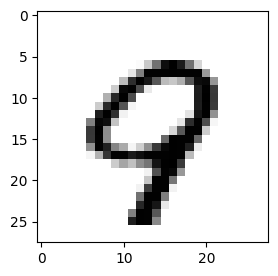

In [4]:
idx = 9900
print ( y_valid[ idx ] )
print ( X_valid[ idx ] )

fig = plt.figure( figsize=(3,3) )
# plt.imshow( X_valid_raw[ idx ].reshape( 28, 28 ), cmap='binary' )
plt.imshow( X_valid[ idx ].reshape( 28, 28 ), cmap='binary' )

In [5]:
# from keras.utils import np_utils
# y_train_onehot = np_utils.to_categorical( y_train , 10)
y_train_onehot = keras.utils.to_categorical( y_train , 10)
print ( y_train_onehot )
# y_test_onehot = np_utils.to_categorical( y_test , 10)
y_test_onehot = keras.utils.to_categorical( y_test , 10)
print ( y_test_onehot )

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [6]:
class VAE(tf.keras.Model):

    def __init__(self, latent_dim, inter_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        self.inter_dim = inter_dim
        self.shape_ = (28, 28, 1)

        img = tf.keras.layers.Input( self.shape_ )

        x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')(img)
        x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)

        x = tf.keras.layers.Dense(self.inter_dim, activation='relu')(x)

        # x = tf.keras.layers.Dense(self.inter_dim//2, activation='relu')(x)
        encoded = tf.keras.layers.Dense(self.latent_dim + self.latent_dim)(x)
        self.encoder = tf.keras.Model(inputs=[img], outputs=[encoded])  # mu and log_var

        z = tf.keras.layers.Input((self.latent_dim,))

        # x = tf.keras.layers.Dense(self.inter_dim//2)(z)
        x = tf.keras.layers.Dense(self.inter_dim)(z)
        x = tf.keras.layers.Dense(7 * 7 * 32, activation='relu')(x)
        x = tf.keras.layers.Reshape(target_shape=(7, 7, 32))(x)
        x = tf.keras.layers.Conv2DTranspose(filters=64,
                                            kernel_size=3,
                                            strides=2,
                                            padding='same',
                                            activation='relu')(x)
        x = tf.keras.layers.Conv2DTranspose(filters=32,
                                            kernel_size=3,
                                            strides=2,
                                            padding='same',
                                            activation='relu')(x)
        x = tf.keras.layers.Conv2DTranspose(filters=1,
                                            kernel_size=3,
                                            strides=1,
                                            padding='same')(x)

        self.decoder = tf.keras.Model(inputs=[z], outputs=[x])

    @tf.function
    def sample(self, eps):
        return self.decode(eps, apply_sigmoid=True)

    @tf.function
    def encode(self, x):
        encoded_= self.encoder([x])
        mean, logvar = tf.split(encoded_, num_or_size_splits=2, axis=1)
        return mean, logvar

    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder([z])
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [7]:
from keras import backend as K

# def log_normal_pdf(sample, mean, logvar, raxis=1):
#     log2pi = tf.math.log(2. * np.pi)
#     return tf.reduce_sum(
#       -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
#       axis=raxis)

def compute_loss(model, x):

    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    # cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    # logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    # logpz = log_normal_pdf(z, 0., 0.)
    # logqz_x = log_normal_pdf(z, mean, logvar)
    # loss_ = -tf.reduce_mean(logpx_z + logpz - logqz_x)

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    cross_ent = tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    kl_loss = -0.5 * K.sum( 1 + logvar - K.square(mean) - K.exp(logvar) , axis=-1 )
    loss_ = tf.reduce_mean( cross_ent + kl_loss )

    return loss_

train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)

@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)

@tf.function
def test_step(model, x_test):
    test_loss(compute_loss(model, x_test))

# def generate_and_save_images(model, epoch, test_sample_x, test_sample_y):
#     mean, logvar = model.encode(test_sample_x, test_sample_y)
#     z = model.reparameterize(mean, logvar)
#     predictions = model.sample(z, test_sample_y)
#     fig = plt.figure(figsize=(4, 4))
#     for i in range(predictions.shape[0]):
#         plt.subplot(4, 4, i + 1)
#         plt.imshow(predictions[i, :, :, 0], cmap='gray')
#         plt.axis('off')
#         plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
#     # plt.show()

# batch_size = 512
# latent_dim = 8
# inter_dim = 128
# n_epochs = 30
# learning_rate = 1e-4
batch_size = 32
latent_dim = 4
inter_dim = 128
n_epochs = 50
learning_rate = 1e-4

import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

train_dataset = ( tf.data.Dataset.from_tensor_slices( ( X_train, y_train_onehot ) )
                    .shuffle( X_train.shape[0] ).batch( batch_size ) )
test_dataset = ( tf.data.Dataset.from_tensor_slices( ( X_test, y_test_onehot ) )
                    .shuffle( X_test.shape[0] ).batch( batch_size ) )

optimizer = tf.keras.optimizers.Adam( learning_rate )

model = VAE( latent_dim, inter_dim )
model.encoder.summary()
model.decoder.summary()

for epoch in range( n_epochs ):
    for train in train_dataset:
        train_step(model, train[0], optimizer)
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)

    for test in test_dataset:
        test_step(model, test[0])
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1, train_loss.result(), test_loss.result()))
    # Reset metrics every epoch
    train_loss.reset_states()
    test_loss.reset_states()
    # generate_and_save_images(model, epoch, test_sample_x, test_sample_y)

# model.save_weights('saved_model/my_checkpoint')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               295040    
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 314888 (1.20 MB)
Trainable params: 314888 (1.20

In [8]:
# for layer in model.encoder.layers:
#     print ( layer.output_shape )

[[-1.0470126   0.6621557  -0.28824884  0.9079598 ]]


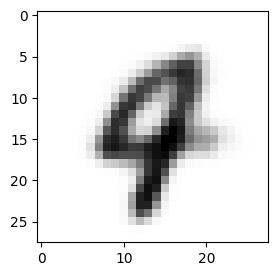

In [16]:
# np.random.seed(100)

latent_vals_ = np.random.randn( 1, latent_dim ).astype( np.float32 )
print ( latent_vals_ )
img_ = model.sample( latent_vals_ )

fig = plt.figure( figsize=(3,3) )
plt.imshow( ( img_[ 0 ].numpy().reshape(28,28) * 255. ), cmap='binary' )

[-1.         -0.77777778 -0.55555556 -0.33333333 -0.11111111  0.11111111
  0.33333333  0.55555556  0.77777778  1.        ]
[-1.         -0.77777778 -0.55555556 -0.33333333 -0.11111111  0.11111111
  0.33333333  0.55555556  0.77777778  1.        ]
[0.38778849 0.30127749]


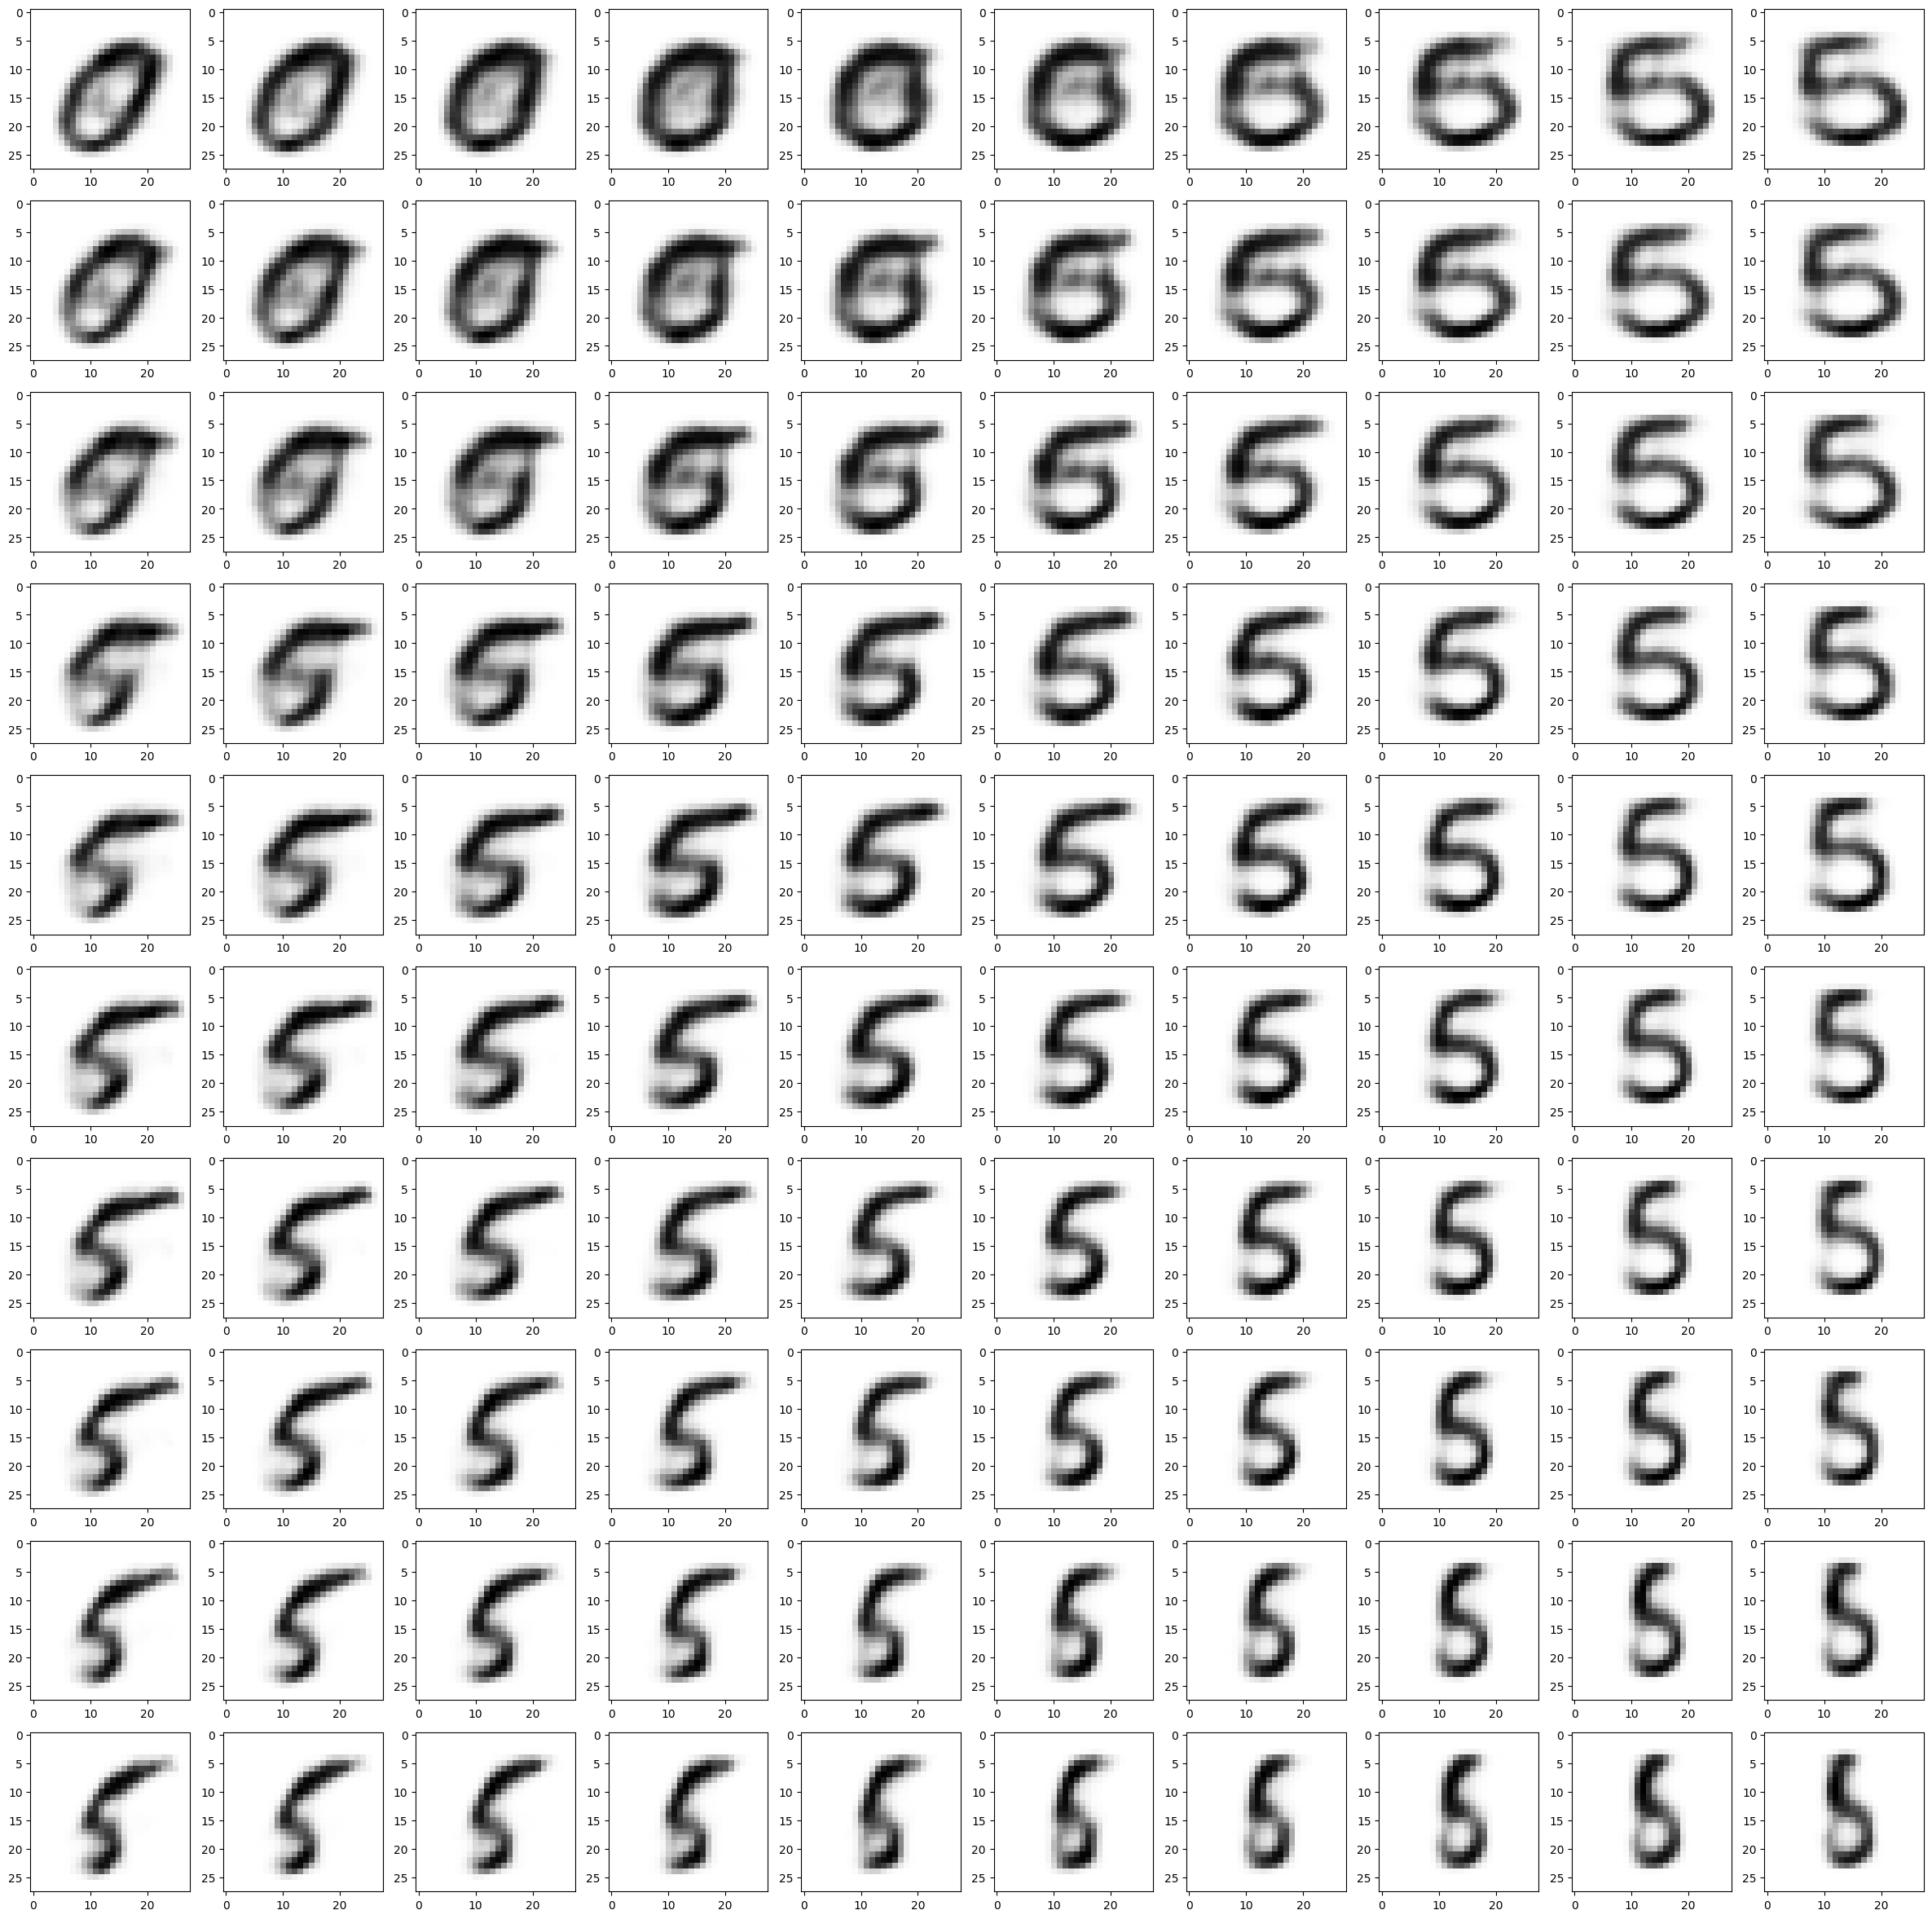

In [12]:
def plot_digits( n ):

    lat_var_dim_0_ = np.linspace( -1., 1. , n )
    lat_var_dim_1_ = np.linspace( -1., 1. , n )
    print ( lat_var_dim_0_ )
    print ( lat_var_dim_1_ )
    latent_vals_ = np.random.randn( ( latent_dim - 2 ) )
    print ( latent_vals_ )

    size_ = 3
    fig_, axes_ = plt.subplots( n, n, figsize=( n * size_ , n * size_ ) )
    for idx_row__ in range( n ):
        for idx_col__ in range( n ):
            ax_ = axes_[ idx_row__, idx_col__ ]
            X__ = np.concatenate( [ np.array( [ lat_var_dim_0_[ idx_col__ ], lat_var_dim_1_[ idx_row__ ] ] ), latent_vals_ ] )
            # X__ = np.concatenate( [ latent_vals_, np.array( [ lat_var_dim_0_[ idx_col__ ], lat_var_dim_1_[ idx_row__ ] ] ) ] )
            # print ( X__)
            X__ = X__.reshape( 1, latent_dim )
            # print ( X__ )
            img_ = model.sample( X__ )
            ax_.imshow( ( img_[ 0 ].numpy().reshape(28,28) * 255. ), cmap='binary' )

plot_digits( 10 )